# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [ ]:
import findspark
findspark.init()

In [1]:
# Do all imports and installs here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark 
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf,isnan, col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_date,year,month

In [3]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql import SparkSession
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
# os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
# os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

### Scope 
This project will integrate I94 immigration data, World temperature data and US demographic data to setup a data warehouse with fact and dimension tables

- Datsasets:

    1. I94 Immigration Data
    2. World Temperature Data
    3. U.S City Demographic Data
    
    
- Tools:
    
    - AWS S3: Data storage 
    - Python for data processing:
        1. pandas - exploratory data analysis on small data set 
        2. PySpark - data processing on larget dataset

#### Describe and Gather Data 

| Data Set | Format | Description |
| ---      | ---    | ---         |
|[I94 Immigration Data](https://travel.trade.gov/research/reports/i94/historical/2016.html)| SAS | Data contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).|
|[World Temperature Data](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)| CSV | This dataset is from Kaggle and contains monthly average temperature data at different country in the world wide.|
|[U.S. City Demographic Data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)| CSV | This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000.|


### Data load and Description: I94 Immigration Data

#### Load I94 Immigration Dataset

In [4]:
# read parquet 
immigration_df = spark.read.parquet("./sas_data")

In [5]:
# check num of row 
immigration_df.count()

3096313

In [6]:
# check head 
immigration_df.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1


In [7]:
# check columns 
immigration_df.columns

['cicid',
 'i94yr',
 'i94mon',
 'i94cit',
 'i94res',
 'i94port',
 'arrdate',
 'i94mode',
 'i94addr',
 'depdate',
 'i94bir',
 'i94visa',
 'count',
 'dtadfile',
 'visapost',
 'occup',
 'entdepa',
 'entdepd',
 'entdepu',
 'matflag',
 'biryear',
 'dtaddto',
 'gender',
 'insnum',
 'airline',
 'admnum',
 'fltno',
 'visatype']

### Data Dictionary: I94 Immigration Dataset 

- `i94yr` = 4 digit year 
- `i94mon` = month 
- `i94cit` = 3 digit code of origin city 
- `i94res` = 	3 digit code for immigrant country of residence
- `i94port` = port of admission
- `arrdate` = arrival date in the USA 
- `i94mode` = 1 digit travel code 
- `i94addr` = state of arrival
- `depdate` = departure date from the USA 
- `i94bir` = Age of Respondent in Years
- `i94visa` = reason for immigration
- `count` = field used for summary statistics
- `dtadfile` = Character Date field - date added to i-94 files 
- `visapost` = Department of state where visa was issued 
- `occup`  = occupation that will be performed in u.s
- `entdepa` = Arrival flag - admitted or paroled into the u.s
- `entdepd` = Departure flag - departed, lost I-94 or is deceased 
- `entdepu` = Update flag 
- `matflag` = Match flag - Match of arrival and departure records 
- `biryear` = 4 digit year of birth
- `dtaddto` = Character Date field - date to which admitted to us.
- `gender` = non-immigrant sex 
- `insnum` = INS number 
- `airline` = Airline used to arrive in us 
- `admnum` = admission number 
- `fltno` = flight number of airline used to arrive in u.s
- `visatype` = class of admission 

#### Load I94 Immigration data's Label dataset to understand dataset

In [8]:
# load label dataset
with open("./I94_SAS_Labels_Descriptions.SAS") as f:
    f_content = f.read()
    f_content = f_content.replace('\t','')

def code_mapper(f_content, idx):
    """
        function to load SAS data 
    """
    
    f_content2 = f_content[f_content.index(idx):]
    f_content2 = f_content2[:f_content2.index(';')].split('\n')
    f_content2 = [i.replace("'","") for i in f_content2]
    
    dic = [i.split('=') for i in f_content2[1:]]
    dic = dict([i[0].strip(), i[1].strip()] for i in dic if len(i) == 2)
    
    return dic

In [9]:
# load 
i94cit_res = code_mapper(f_content, "i94cntyl")
i94port = code_mapper(f_content, "i94prtl")
i94mode = code_mapper(f_content, "i94model")
i94addr = code_mapper(f_content, "i94addrl")
i94visa = {'1':'Business',
'2': 'Pleasure',
'3' : 'Student'}

In [12]:
i94cit_res

{'582': 'MEXICO Air Sea, and Not Reported (I-94, no land arrivals)',
 '236': 'AFGHANISTAN',
 '101': 'ALBANIA',
 '316': 'ALGERIA',
 '102': 'ANDORRA',
 '324': 'ANGOLA',
 '529': 'ANGUILLA',
 '518': 'ANTIGUA-BARBUDA',
 '687': 'ARGENTINA',
 '151': 'ARMENIA',
 '532': 'ARUBA',
 '438': 'AUSTRALIA',
 '103': 'AUSTRIA',
 '152': 'AZERBAIJAN',
 '512': 'BAHAMAS',
 '298': 'BAHRAIN',
 '274': 'BANGLADESH',
 '513': 'BARBADOS',
 '104': 'BELGIUM',
 '581': 'BELIZE',
 '386': 'BENIN',
 '509': 'BERMUDA',
 '153': 'BELARUS',
 '242': 'BHUTAN',
 '688': 'BOLIVIA',
 '717': 'BONAIRE, ST EUSTATIUS, SABA',
 '164': 'BOSNIA-HERZEGOVINA',
 '336': 'BOTSWANA',
 '689': 'BRAZIL',
 '525': 'BRITISH VIRGIN ISLANDS',
 '217': 'BRUNEI',
 '105': 'BULGARIA',
 '393': 'BURKINA FASO',
 '243': 'BURMA',
 '375': 'BURUNDI',
 '310': 'CAMEROON',
 '326': 'CAPE VERDE',
 '526': 'CAYMAN ISLANDS',
 '383': 'CENTRAL AFRICAN REPUBLIC',
 '384': 'CHAD',
 '690': 'CHILE',
 '245': 'CHINA, PRC',
 '721': 'CURACAO',
 '270': 'CHRISTMAS ISLAND',
 '271': 'COCO

In [13]:
# create country_df 
df_country_code = pd.DataFrame(list(i94cit_res.items()), columns=['code','country'])

In [14]:
df_country_code.head()

,code,country
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [15]:
df_country_code.count()

code       289
country    289
dtype: int64

In [ ]:
# check i94port => us city code 
i94port

In [17]:
# create city_code_df
df_city_code = pd.DataFrame(list(i94port.items()), columns=['code','city'])
df_city_code.head()

,code,city
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"


In [18]:
# cheking city_code number of rows
df_city_code.count()

code    660
city    660
dtype: int64

In [19]:
# check i94mode 
i94mode

{'1': 'Air', '2': 'Sea', '3': 'Land', '9': 'Not reported'}

In [ ]:
# check i94addr => state 
i94addr

In [20]:
# create state_df  
df_state_code = pd.DataFrame(list(i94addr.items()), columns=['code','state'])
df_state_code.head()

,code,state
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


In [21]:
df_state_code.count()

code     55
state    55
dtype: int64

In [22]:
# check visa 
i94visa

{'1': 'Business', '2': 'Pleasure', '3': 'Student'}

### Data Load and Description:  U.S City demography dataset

This data comes from OpenSoft and contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. Original data comes from the US Census Bureau's 2015 American Community Survey.

In [25]:
demog_path = "./us-cities-demographics.csv"

demog_df = spark.read\
    .option("delimiter",";")\
    .option("header","True")\
    .csv(demog_path)

In [26]:
demog_df.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [27]:
# check num of row 
demog_df.count()

2891

In [28]:
demog_df.columns

['City',
 'State',
 'Median Age',
 'Male Population',
 'Female Population',
 'Total Population',
 'Number of Veterans',
 'Foreign-born',
 'Average Household Size',
 'State Code',
 'Race',
 'Count']

##### Data Dictionary: Demography dataset

- `city` = City Name 
- `State` = US state 
- ` Median age` = Median age of the population 
- `Male Population` = Count of male population 
- `Female population` = count of female population 
- `Total population` = Count of total population
- `Number of Veterans` = Count of total veterans 
- `Foreign born` = Count of residents of the city that were not born in the city 
- `Average Household Size` = Average city household size 
- `State Code` = Code of the US state 
- `Race` = Respondent race 
- `Count` = Count of city's individual per race

### Data Load and Description: World Temperature Dataset

The World Temperature dataset comes from Kaggle and represents global land temperatures by city.

#### Load World Temperature dataset

In [29]:
# load world temperature dataset 
temp_path = "./GlobalLandTemperaturesByCity.csv"

# read csv 
temp_df = spark.read\
    .option("delimiter",",")\
    .option("header","True")\
    .csv(temp_path)

In [30]:
# check temp_df 
temp_df.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E
3,1744-02-01,None,None,Århus,Denmark,57.05N,10.33E
4,1744-03-01,None,None,Århus,Denmark,57.05N,10.33E


In [31]:
# check columns 
temp_df.columns

['dt',
 'AverageTemperature',
 'AverageTemperatureUncertainty',
 'City',
 'Country',
 'Latitude',
 'Longitude']

In [32]:
# check num row 
temp_df.count()

8599212

#### Data Dictionary: World Temperature Dataset

- `dt` = Date 
- `AverageTemperature` = Global average land temperature in celsius 
- `AverageTemperatureUncertainty` = 95% confidence interval around the average 
- `City` = name of city 
- `Country` = name of country 
- `Latitude` = city latitude 
- `Longitude` = city Longitude

## Step 2: Explore and Assess the Data

#### Explore the data 
1. Use pandas and pyspark for exploratory data analysis to understand on datasets
2. split datasets to Fact-dimension tables and checking missing values

### Explore Data: Immigration dataset

In [33]:
# check schema 
immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

#### Missing values

In [34]:
# checking total number of rows
total = immigration_df.count()

In [35]:
# create missing_df to count missing values
df_agg = immigration_df.agg(*[
    F.count(F.when(F.isnull(c), c)).alias(c) for c in immigration_df.columns
])

df_agg_pd = df_agg.toPandas()

df_agg_pd = pd.melt(df_agg_pd, var_name='cols',value_name='values')
df_agg_pd['%_missing_values'] = 100 * df_agg_pd['values']/total

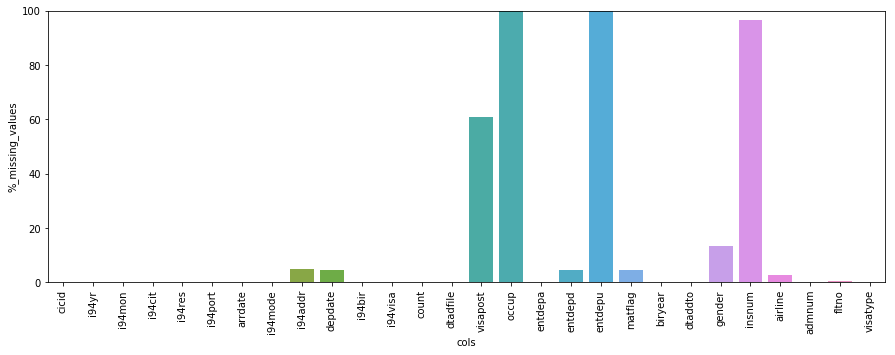

In [36]:
# visualize
plt.figure(figsize=(15,5))
ax = sns.barplot(x='cols',y='%_missing_values', data=df_agg_pd)
ax.set_ylim(0,100)
# rotation x key
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [37]:
# drop columns
drop_cols = ['visapost','occup','entredepu','insnum']

immigration_df = immigration_df.drop(*drop_cols)

# drop duplicates 
immigration_df = immigration_df.drop_duplicates(['cicid'])

In [38]:
immigration_df.count()

3096313

## Explore Dataset: Demography dataset

In [39]:
# check count
demog_df.count()

2891

In [40]:
# print dmog_df schema 
demog_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



#### Checking missing values: Demography

In [41]:
# create missing_df_demog
demog_df_missing = demog_df.agg(*[
        F.count(F.when(F.isnull(c), c)).alias(c) for c in demog_df.columns
])

In [42]:
demog_df_missing.toPandas().head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,0,0,0,3,3,0,13,13,16,0,0,0


In [43]:
# drop missing values 

drop_cols = ['Male Population','Female Population','Number of Veterans','Foreign-born','Average Household Size']


demog_df = demog_df.dropna(subset=drop_cols)
demog_df = demog_df.drop_duplicates(subset=['City','State','State Code','Race'])

## Explore Dataset: Temperature dataset

In [44]:
temp_df.show(5)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
only showing top 5 rows



In [45]:
# count total count of temperature dataset
total_temp = temp_df.count()
total_temp

8599212

In [46]:
# check schema 
temp_df.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



#### checking missing values: temperature dataset

In [47]:
# create temp_df_missing
temp_df_missing = temp_df.agg(*[
        F.count(F.when(F.isnull(c), c)).alias(c) for c in temp_df.columns
])

In [48]:
temp_df_missing.toPandas().head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,0,364130,364130,0,0,0,0


In [49]:
# convert temp_df_missing to pandas df
temp_df_pd = temp_df_missing.toPandas()
temp_df_pd = pd.melt(temp_df_pd, var_name='cols',value_name='values')

temp_df_pd['%_missing_values'] = 100 * temp_df_pd['values']/total_temp

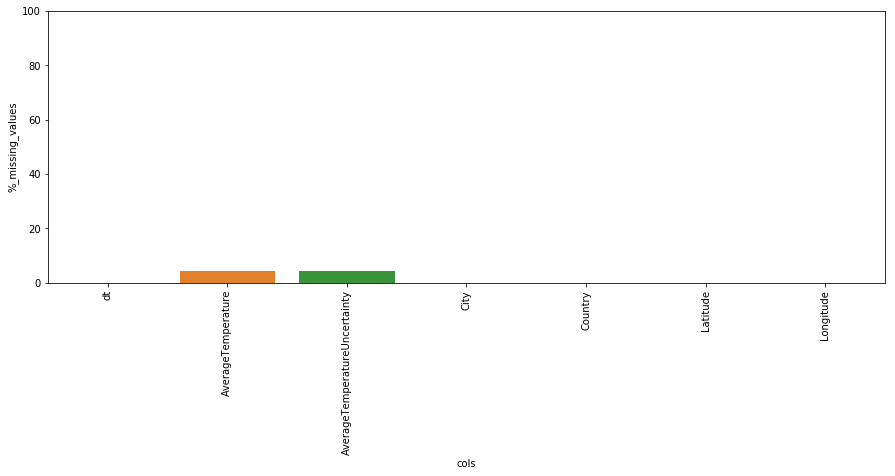

In [50]:
# visualize
plt.figure(figsize=(15,5))
ax = sns.barplot(x='cols',y='%_missing_values', data=temp_df_pd)
ax.set_ylim(0,100)
# rotation x key
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [51]:
# set drop columns list 
drop_cols = ['AverageTemperature','AverageTemperatureUncertainty']

# drop 
temp_df = temp_df.dropna(subset=drop_cols)

In [52]:
# checking count
temp_df.count()

8235082

In [53]:
temp_df.show()

+----------+-------------------+-----------------------------+-----+-------+--------+---------+
|        dt| AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+-------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|              6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1744-04-01| 5.7879999999999985|           3.6239999999999997|Århus|Denmark|  57.05N|   10.33E|
|1744-05-01|             10.644|           1.2830000000000001|Århus|Denmark|  57.05N|   10.33E|
|1744-06-01| 14.050999999999998|                        1.347|Århus|Denmark|  57.05N|   10.33E|
|1744-07-01|             16.082|                        1.396|Århus|Denmark|  57.05N|   10.33E|
|1744-09-01| 12.780999999999999|                        1.454|Århus|Denmark|  57.05N|   10.33E|
|1744-10-01|               7.95|                         1.63|Århus|Denmark|  57.05N|   10.33E|
|1744-11-01|  4.638999999999999|        

In [54]:
# drop duplicates row 
temp_df = temp_df.drop_duplicates(subset=['dt','City','Country'])

### Step 3: Define the Data Model


##### 3.1 Conceptual Data Model

![nn](./capstone_tables.png)

#### Data Pipeline Build Up steps

1. Load datasets 
2. clean the i94 immigration dataset to create spark dataframe for each month
    and create Fact-immigration table.
3. create airline dataframe from i94 immigration dataset and clean, then create
    airline dimensional table, save as parquet.
4. clean us-demograph dataset and create demograhpy dimensional table, save as parquet.
5. clean global temperature dataset and create temperature dimensional table, save as parquet

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

### Create the data model: fact-immigration-table

In [55]:
# rename columns function 
def rename_columns(table, new_columns):
    """
        rename column name on spark dataframe
        
        input:
            - table: df to rename
            - new_colmns: new name of columns list
        output:
            - renamed df
    """
    
    for original, new in zip(table.columns, new_columns):
        table = table.withColumnRenamed(original, new)
    return table

In [56]:
# convert to datetime Type
def SAS_to_date(date):
    if date is not None:
        return pd.to_timedelta(date, unit='D') + pd.Timestamp('1960-1-1')

In [57]:
# set udf 
SAS_to_date_udf = udf(SAS_to_date, DateType())

In [58]:
# Select columns to create Fact table 
target_cols = ['cicid','i94yr','i94mon','i94res','i94port','arrdate','depdate','i94addr','gender','visatype','fltno']

# new column name list
# new cos 
new_cols = ['cic_id','year','month','country_code','city_code','arrive_date','depart_date','state_code','gender','visa_type','flight_num']

In [59]:
# create fact_immigration table 
fact_immigration_df = immigration_df.select(target_cols).distinct()\
    .withColumn('immigration_id', monotonically_increasing_id())

In [60]:
# rename columns on fact_immigration_df 
fact_immigration_df = rename_columns(fact_immigration_df,new_cols)

In [61]:
# checking 
fact_immigration_df

DataFrame[cic_id: double, year: double, month: double, country_code: double, city_code: string, arrive_date: double, depart_date: double, state_code: string, gender: string, visa_type: string, flight_num: string, immigration_id: bigint]

In [62]:
# apply convert date 
fact_immigration_df = fact_immigration_df.withColumn('arrive_date',\
                                                     SAS_to_date_udf(col('arrive_date')))
fact_immigration_df = fact_immigration_df.withColumn('depart_date',\
                                                    SAS_to_date_udf(col('depart_date')))

In [63]:
# convert country code , year, month to integer
fact_immigration_df = fact_immigration_df.withColumn('country_code',F.col('country_code').cast('integer'))
fact_immigration_df = fact_immigration_df.withColumn('year',F.col('year').cast('integer'))
fact_immigration_df = fact_immigration_df.withColumn('month',F.col('month').cast('integer'))


In [64]:
fact_immigration_df

DataFrame[cic_id: double, year: int, month: int, country_code: int, city_code: string, arrive_date: date, depart_date: date, state_code: string, gender: string, visa_type: string, flight_num: string, immigration_id: bigint]

In [60]:
fact_immigration_df.show(3)

+------+----+-----+------------+---------+-----------+-----------+----------+------+---------+----------+--------------+
|cic_id|year|month|country_code|city_code|arrive_date|depart_date|state_code|gender|visa_type|flight_num|immigration_id|
+------+----+-----+------------+---------+-----------+-----------+----------+------+---------+----------+--------------+
| 299.0|2016|    4|         103|      NYC| 2016-04-01| 2016-04-06|        NY|  null|       WT|     00087|             0|
| 305.0|2016|    4|         103|      NYC| 2016-04-01| 2016-04-11|        NY|  null|       WT|     00087|             1|
| 496.0|2016|    4|         103|      CHI| 2016-04-01| 2016-04-04|        IL|  null|       WB|     00065|             2|
+------+----+-----+------------+---------+-----------+-----------+----------+------+---------+----------+--------------+
only showing top 3 rows



In [ ]:
# write parquet 
fact_immigration_df.write.parquet("./fact_immigration",mode="overwrite")

### Create Data model: Dimension-airline-table

In [65]:
immigration_df

DataFrame[cicid: double, i94yr: double, i94mon: double, i94cit: double, i94res: double, i94port: string, arrdate: double, i94mode: double, i94addr: string, depdate: double, i94bir: double, i94visa: double, count: double, dtadfile: string, entdepa: string, entdepd: string, entdepu: string, matflag: string, biryear: double, dtaddto: string, gender: string, airline: string, admnum: double, fltno: string, visatype: string]

In [66]:
immigration_df.show(3)

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+-------+-------+-------+-------+-------+--------+------+-------+---------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|airline|         admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+-------+-------+-------+-------+-------+--------+------+-------+---------------+-----+--------+
|299.0|2016.0|   4.0| 103.0| 103.0|    NYC|20545.0|    1.0|     NY|20550.0|  54.0|    2.0|  1.0|20160401|      O|      O|   null|      M| 1962.0|06292016|  null|     OS|5.5425872433E10|00087|      WT|
|305.0|2016.0|   4.0| 103.0| 103.0|    NYC|20545.0|    1.0|     NY|20555.0|  63.0|    2.0|  1.0|20160401|      O|      O|   null|      M| 1953.0|06292016|  null|     OS|5.5425817433E10|00087|     

In [67]:
# create airline_df 
target_cols = ['cicid','airline','admnum','fltno','visatype']

dim_airline_df = immigration_df.select(target_cols)\
    .withColumn('immi_airline_id',monotonically_increasing_id())

In [68]:
# rename columns 
new_cols = ['cic_id','airline','admission_num','flight_num','visa_type']

dim_immi_airline = rename_columns(dim_airline_df, new_cols)

In [69]:
#checking 
dim_immi_airline.show(3)

+------+-------+---------------+----------+---------+---------------+
|cic_id|airline|  admission_num|flight_num|visa_type|immi_airline_id|
+------+-------+---------------+----------+---------+---------------+
| 299.0|     OS|5.5425872433E10|     00087|       WT|              0|
| 305.0|     OS|5.5425817433E10|     00087|       WT|              1|
| 496.0|     OS|5.5428623333E10|     00065|       WB|              2|
+------+-------+---------------+----------+---------+---------------+
only showing top 3 rows



In [70]:
dim_immi_airline

DataFrame[cic_id: double, airline: string, admission_num: double, flight_num: string, visa_type: string, immi_airline_id: bigint]

In [74]:
# write dim_immi_airline table as parquet 
dim_immi_airline.write.parquet("./dim_immi_airline",mode='overwrite')

- - -

### Create Data model: dimension-demography-table

In [71]:
demog_df

DataFrame[City: string, State: string, Median Age: string, Male Population: string, Female Population: string, Total Population: string, Number of Veterans: string, Foreign-born: string, Average Household Size: string, State Code: string, Race: string, Count: string]

In [72]:
demog_df.columns

['City',
 'State',
 'Median Age',
 'Male Population',
 'Female Population',
 'Total Population',
 'Number of Veterans',
 'Foreign-born',
 'Average Household Size',
 'State Code',
 'Race',
 'Count']

In [73]:
# rename columns
new_cols = ['city','state','median_age','male','female','total','veteran','foreign_born','avg_house_size','state_code','race','count']

dim_demog_df= rename_columns(demog_df,new_cols)

# add id pk column 
dim_demog_df = dim_demog_df.withColumn('demog_id',monotonically_increasing_id())

In [74]:
int_cols = ['male', 'female', 'total',
                'veteran', 'foreign_born', 'count']
float_cols = ['median_age','avg_house_size']


In [75]:
def convert_to_target_type(df, cols,target_type=""):
    """
    Convert the column to datatype you want 
    Args:
        df : Spark dataframe to be processed.
        cols : List of column names that should be converted to datatype
        tartget_type : target type to convert to 
    Returns:
        df : Processed Spark dataframe
    """

    for col in [col for col in cols if col in df.columns]:
        df = df.withColumn(col, df[col].cast(target_type))
    return df

In [76]:
dim_demog_df = convert_to_target_type(dim_demog_df, int_cols, "integer")
dim_demog_df = convert_to_target_type(dim_demog_df, float_cols, "float")

In [77]:
dim_demog_df

DataFrame[city: string, state: string, median_age: float, male: int, female: int, total: int, veteran: int, foreign_born: int, avg_house_size: float, state_code: string, race: string, count: int, demog_id: bigint]

In [82]:
dim_demog_df.show(3)

+------------+----------+----------+-----+------+-----+-------+------------+--------------+----------+--------------------+-----+--------+
|        city|     state|median_age| male|female|total|veteran|foreign_born|avg_house_size|state_code|                race|count|demog_id|
+------------+----------+----------+-----+------+-----+-------+------------+--------------+----------+--------------------+-----+--------+
|Arden-Arcade|California|      41.5|47596| 48680|96276|   6511|       13458|          2.18|        CA|Black or African-...|13647|       0|
| Bloomington| Minnesota|      40.9|43318| 43118|86436|   6176|       10728|           2.3|        MN|Black or African-...| 5828|       1|
|  Buena Park|California|      35.7|41593| 41671|83264|   3116|       28430|          3.55|        CA|               White|48412|       2|
+------------+----------+----------+-----+------+-----+-------+------------+--------------+----------+--------------------+-----+--------+
only showing top 3 rows



In [83]:
# write dim_demog table as parquet 
dim_demog_df.write.parquet("./dim_demog",mode='overwrite')

### Create Data model: Dimension-temperature-table

In [84]:
temp_df.show(3)

+----------+------------------+-----------------------------+--------+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|    City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+--------+-------+--------+---------+
|1750-02-01|            10.122|                        2.166|A Coruña|  Spain|  42.59N|    8.73W|
|1752-12-01|             2.242|                        1.175| Aalborg|Denmark|  57.05N|   10.33E|
|1753-02-01|             8.237|                         2.77|A Coruña|  Spain|  42.59N|    8.73W|
+----------+------------------+-----------------------------+--------+-------+--------+---------+
only showing top 3 rows



In [78]:
# filter by only United States 
temp_df_usa = temp_df.filter(temp_df.Country == 'United States')

In [79]:
temp_df_usa

DataFrame[dt: string, AverageTemperature: string, AverageTemperatureUncertainty: string, City: string, Country: string, Latitude: string, Longitude: string]

In [80]:
# rename columns 
new_cols = ['dt','avg_temp','avg_temp_uncer','city','country','lat','long']

temp_df_usa= rename_columns(temp_df_usa,new_cols)

In [81]:
# convert dt to date_time
temp_df_usa = temp_df_usa.withColumn("dt",to_date(F.col("dt"),'yyyy-MM-dd'))



In [82]:
# convert it to float
float_cols = ["avg_temp","avg_temp_uncer"]

temp_df_usa = convert_to_target_type(temp_df_usa, float_cols, "float")

In [83]:
# get year, month columns 
temp_df_usa = temp_df_usa.withColumn("year",year(F.col("dt")))
temp_df_usa = temp_df_usa.withColumn("month",month(F.col("dt")))

# add id column 
temp_df_usa = temp_df_usa.withColumn('temp_id',monotonically_increasing_id())

In [84]:
# drop dt 
dim_temp = temp_df_usa.drop('dt')

In [92]:
dim_temp.show(3)

+--------+--------------+-------+-------------+------+-------+----+-----+-------+
|avg_temp|avg_temp_uncer|   city|      country|   lat|   long|year|month|temp_id|
+--------+--------------+-------+-------------+------+-------+----+-----+-------+
|  26.553|         2.291|Abilene|United States|32.95N|100.53W|1821|    7|      0|
|  17.284|         3.631|Abilene|United States|32.95N|100.53W|1827|    4|      1|
|   5.296|         2.678|Abilene|United States|32.95N|100.53W|1832|    1|      2|
+--------+--------------+-------+-------------+------+-------+----+-----+-------+
only showing top 3 rows



In [85]:
# checking 2016 
dim_temp.filter(temp_df_usa.year == 2016).show()


+--------+--------------+----+-------+---+----+----+-----+-------+
|avg_temp|avg_temp_uncer|city|country|lat|long|year|month|temp_id|
+--------+--------------+----+-------+---+----+----+-----+-------+
+--------+--------------+----+-------+---+----+----+-----+-------+



In [94]:
dim_temp

DataFrame[avg_temp: float, avg_temp_uncer: float, city: string, country: string, lat: string, long: string, year: int, month: int, temp_id: bigint]

In [95]:
# write temperature data frame 
dim_temp.write.parquet("./dim_temp",mode="overwrite")

_ _ _

### Create Data model: Dimension-country-code

In [101]:
df_country_code

,code,country
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA
5,324,ANGOLA
6,529,ANGUILLA
7,518,ANTIGUA-BARBUDA
8,687,ARGENTINA
9,151,ARMENIA


In [94]:
df_country_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 2 columns):
code       289 non-null object
country    289 non-null object
dtypes: object(2)
memory usage: 4.6+ KB


In [98]:
# convert code column's dtype into int 
df_country_code['code'] = df_country_code['code'].astype('int')

In [99]:
df_country_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 2 columns):
code       289 non-null int64
country    289 non-null object
dtypes: int64(1), object(1)
memory usage: 4.6+ KB


In [104]:
df_country_code.count()

code       289
country    289
dtype: int64

In [101]:
# save country_code table as parquet 
df_country_code.to_csv("./dim_country")

_ __

### Create Data model: dimension- citycode Table

In [102]:
df_city_code.head()

,code,city
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"


In [103]:
df_city_code.count()

code    660
city    660
dtype: int64

In [105]:
# write as csv 
df_city_code.to_csv("./dim_city")

### Create Data model: Dimension - State Table

In [106]:
df_state_code.head(), df_state_code.count()

(  code       state
 0   AL     ALABAMA
 1   AK      ALASKA
 2   AZ     ARIZONA
 3   AR    ARKANSAS
 4   CA  CALIFORNIA, code     55
 state    55
 dtype: int64)

In [108]:
# write as csv 
df_state_code.to_csv("./dim_state")

___

### Create Data model: Dimension - Visa Table

In [109]:
# checking immigration dataset to get columns related to visa
immigration_df

DataFrame[cicid: double, i94yr: double, i94mon: double, i94cit: double, i94res: double, i94port: string, arrdate: double, i94mode: double, i94addr: string, depdate: double, i94bir: double, i94visa: double, count: double, dtadfile: string, entdepa: string, entdepd: string, entdepu: string, matflag: string, biryear: double, dtaddto: string, gender: string, airline: string, admnum: double, fltno: string, visatype: string]

In [87]:
# create visatype df from visatype column 
df_visatype = immigration_df.select(['visatype','i94visa']).distinct()
df_visatype.show()

+--------+-------+
|visatype|i94visa|
+--------+-------+
|      CP|    2.0|
|     CPL|    2.0|
|     GMB|    1.0|
|     SBP|    2.0|
|      B1|    1.0|
|       I|    1.0|
|      F2|    3.0|
|      E1|    1.0|
|      M2|    3.0|
|      WB|    1.0|
|      WT|    2.0|
|      E2|    1.0|
|      M1|    3.0|
|     GMT|    2.0|
|      B2|    2.0|
|      I1|    1.0|
|      F1|    3.0|
+--------+-------+



In [88]:
# get_visa_type2
def get_visa_group(visa):
    """
        change i94visa to visa group
    """
    visatype2 = ''
    if visa == 1.0:
        visatype2= 'Business'
    elif visa == 2.0:
        visatype2 = 'Pleasure'
    elif visa == 3.0:
        visatype2 = "Student"
    return visatype2

In [89]:
# set udf to create visagroup function
get_visa_group_udf = udf(lambda x:get_visa_group(x))

In [90]:
# create visa_group on visatype dataframe 
df_visatype = df_visatype.withColumn('visa_group',get_visa_group_udf('i94visa'))
# rename on visatype to visa_type 
df_visatype = df_visatype.withColumnRenamed("visatype","visa_type")\
    .withColumnRenamed("i94visa","visa_code")

# add an id to visatype
df_visatype = df_visatype.withColumn("visa_type_key",monotonically_increasing_id())

In [114]:
df_visatype.show()

+---------+---------+----------+-------------+
|visa_type|visa_code|visa_group|visa_type_key|
+---------+---------+----------+-------------+
|       CP|      2.0|  Pleasure|  60129542144|
|      CPL|      2.0|  Pleasure| 335007449088|
|      GMB|      1.0|  Business| 395136991232|
|      SBP|      2.0|  Pleasure| 541165879296|
|       B1|      1.0|  Business| 566935683072|
|        I|      1.0|  Business| 764504178688|
|       F2|      3.0|   Student| 816043786240|
|       E1|      1.0|  Business| 987842478080|
|       M2|      3.0|   Student|1056561954816|
|       WB|      1.0|  Business|1099511627776|
|       WT|      2.0|  Pleasure|1142461300736|
|       E2|      1.0|  Business|1176821039104|
|       M1|      3.0|   Student|1314259992576|
|      GMT|      2.0|  Pleasure|1314259992577|
|       B2|      2.0|  Pleasure|1331439861760|
|       I1|      1.0|  Business|1443109011456|
|       F1|      3.0|   Student|1529008357376|
+---------+---------+----------+-------------+



In [105]:
df_visatype

DataFrame[visa_type: string, visa_code: double, visa_group: string, visa_type_key: bigint]

In [195]:
# save visatype dataframe as dim_visa
df_visatype.write.parquet("./dim_visa",mode='overwrite')

___

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

- Data Quality Checks:
    1. Data schema of every dimensional table matchs data model 
    2. No empty table after running ETL data pipeline

In [97]:
# Perform quality checks here
def quality_checks(df, table_name):
    """
    Check count of dataframe correspond to table
    
        df: spark dataframe to check counts on
        table_name: corresponding name of table
    """
    total_count = df.count()

    if total_count == 0:
        print(f"Data quality check failed for {table_name} with zero records!")
    else:
        print(f"Data quality check passed for {table_name} with {total_count:,} records.")
    return 0

In [107]:
# run quality_check function 
table_dict = {
    'fact_immigration': fact_immigration_df,
    'dim_airline': dim_immi_airline,
    'dim_demography':dim_demog_df,
    'dim_temperature':dim_temp,
    'dim_visatype':df_visatype
}

for table_name, table_df in table_dict.items():
    quality_checks(table_df,table_name)

Data quality check passed for fact_immigration with 3,096,313 records.
Data quality check passed for dim_airline with 3,096,313 records.
Data quality check passed for dim_demography with 2,875 records.
Data quality check passed for dim_temperature with 639,649 records.
Data quality check passed for dim_visatype with 17 records.


In [108]:
# Perform quality checks here
def label_quality_checks(df, table_name):
    """
    Check count of dataframe correspond to table
    
        df: pandas dataframe to check counts on
        table_name: corresponding name of table
    """
    total_count = df.count()[0]

    if total_count == 0:
        print(f"Data quality check failed for {table_name} with zero records!")
    else:
        print(f"Data quality check passed for {table_name} with {total_count} records.")
    return 0

In [110]:
# run quality_check function 
label_dict = {
    'dim_country': df_country_code, 
    'dim_city': df_city_code, 
    'dim_state': df_state_code
}

for table_name, table_df in label_dict.items():
    label_quality_checks(table_df,table_name)

Data quality check passed for dim_country with 289 records.
Data quality check passed for dim_city with 660 records.
Data quality check passed for dim_state with 55 records.


### 4.3 Data Dictionary

#### Fact-immigration

- `immigration_id` = primary key of immigration table 
- `cic_id` = unique record id 
- `year` = 4 digit year 
- `month` = digit month 
- `country_code` = country code of residence 
- `city_code` = arrival city code 
- `arrive_date` = arrival date in the USA 
- `depart_date` = departure date from the USA 
- `state_code` = arrival state code of USA 
- `gender` = gender 
- `visa_type` = class of visa admission
- `flight_num` = flight number

#### Dimension-demography Table

- `demog_id` = primary key of table
- `city` = City Name 
- `State` = US state 
- `median_age` = Median age of the population 
- `male` = Count of male population 
- `female` = count of female population 
- `total` = Count of total population
- `veteran` = Count of total veterans 
- `foreign_born` = Count of residents of the city that were not born in the city 
- `avg_house_size` = Average city household size 
- `state_code` = Code of the US state 
- `race` = Respondent race 
- `count` = Count of city's individual per race

#### Dimension-Temperature Table
- `temp_id` = primary key of temperature table 
- `avg_temp` = average temperature 
- `avg_temp_uncer` = average temperature of uncertainty
- `city` = city name 
- `country` = country name 
- `lat` = latitude 
- `long`= longitude 
- `year` = digit year 
- ` month` = digit month

#### Dimension-Airline Table
- `immi_airline_id` = primary key of AIrline Table 
- `cic_id` = unique record of immigration dataset 
- `airline` = the code of airline 
- `admission_num` = addmission number of immigration 
- `flight_num` = flight number

#### Dimension-Visa Table

- `visa_type_key` = primary key of visa table 
- `visa_type` = code of visa type 
- `visa_code` = numeric code of reason of immigration to USA
- `visa_group` = reason of immigration

#### Dimension-country Table 
- `code` = global country code 
- `country` = country name
#### Dimension-state table 
- `code` = state code of U.S
- `state` = state name 
#### Dimension-city table 
- `code` = city code of U.S
- `city` = city name of U.S

## Step 5: Complete Project Write Up


### Tools and Technologies 
1. AWS S3 Bucket for Data Lake and Data warehouse 
2. Pandas for exploratory data analysis on small dataset 
3. PySpark for data processing to transform staging table to fact-dimension table on larget dataset

### Data Update Frequency 
1. I94 Immigration dataset and Temperature dataset is updated monthly, then dimension tables on data warehouse, data lake should be updated monthly 

### Future Desing Considerations
1. IF the data was increased by 100x:
    - If Spark with standalone server mode can not process 100x dataset, we could consider to use 
        AWS EMR cluster with increasing number of node on AWS EMR cluster.
2. IF The data populates a dashboard that must be updated on a daily basis by 7am every day:
    - To automate data processing, we could consider to build up ETL data pipeline to scheduling the task.
3. IF  the database needed to be accessed by 100+ people:
    - We could consider to put the database on Aws Redshift as Data Warehouse.